In [1]:
%pip install torch torchaudio jiwer sox

Note: you may need to restart the kernel to use updated packages.


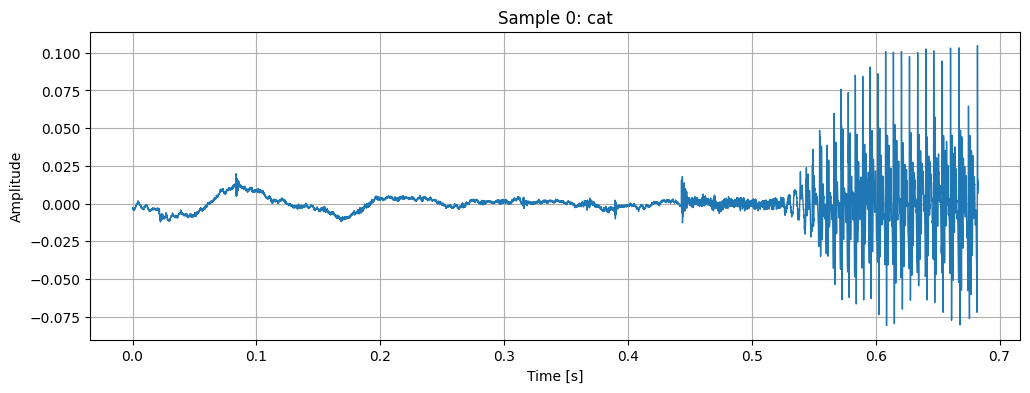

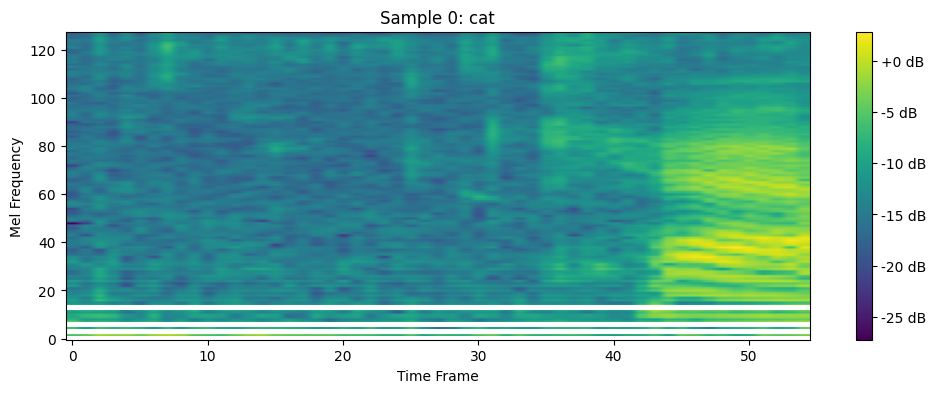

/home/japerez/miniconda3/envs/tpln/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [10, 1, 128, 81]

In [6]:

import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch import nn
from torch.utils.data import DataLoader
from torchaudio.transforms import MelSpectrogram
from torch.nn import Module, Conv1d, Linear, TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
from jiwer import wer  # Assuming jiwer is installed for WER calculation

# Ensure data directory exists
os.makedirs("_data/speechcommands", exist_ok=True)

os.makedirs("_data/speechcommands", exist_ok=True)
train_dataset = torchaudio.datasets.SPEECHCOMMANDS("_data/speechcommands", url="https://github.com/jaspock/me/raw/main/docs/materials/transformers/assets/datasets/filtered_datasets/speech_commands_v0.02.tar.gz", subset="validation", download=True)
test_dataset = torchaudio.datasets.SPEECHCOMMANDS("_data/speechcommands", url="https://github.com/jaspock/me/raw/main/docs/materials/transformers/assets/datasets/filtered_datasets/speech_commands_v0.02.tar.gz", subset="testing", download=True)

# Function to plot the waveform
def plot_waveform(waveform, sample_rate, title="Waveform"):
    waveform = waveform.numpy()
    time_axis = torch.linspace(0, waveform.shape[1] / sample_rate, waveform.shape[1])
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, waveform[0], linewidth=1)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

# Function to plot the Mel spectrogram
def plot_mel_spectrogram(waveform, sample_rate, title="Mel Spectrogram"):
    mel_spectrogram = MelSpectrogram(sample_rate=sample_rate)(waveform)
    plt.figure(figsize=(12, 4))
    plt.imshow(mel_spectrogram.log2()[0].detach().numpy(), cmap='viridis', aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel("Time Frame")
    plt.ylabel("Mel Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Example waveform and spectrogram
i = 0
waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[0]
# waveform, sample_rate, label = train_dataset[i]
plot_waveform(waveform, sample_rate, title=f"Sample {i}: {label}")
plot_mel_spectrogram(waveform, sample_rate, title=f"Sample {i}: {label}")

# Speech Recognition Model
class SpeechRecognitionModel(Module):
    def __init__(self, num_classes=29, input_size=128, num_heads=4, num_layers=3, hidden_size=256):
        super().__init__()
        self.conv1 = Conv1d(1, 32, kernel_size=3, stride=2)
        self.conv2 = Conv1d(32, 64, kernel_size=3, stride=2)
        transformer_layer = TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size)
        self.transformer_encoder = TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.fc = Linear(input_size, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.permute(2, 0, 1)  # Change format to (seq_len, batch, features)
        x = self.transformer_encoder(x)
        x = self.fc(x)
        return x

# Imports adicionales necesarios
from torch.nn.utils.rnn import pad_sequence

# Función de procesamiento de datos
def data_processing(batch):
    spectrogram_transform = MelSpectrogram()
    tensors, targets = [], []
    for (waveform, _, label, _, _) in batch:
        spec = spectrogram_transform(waveform).squeeze(0).transpose(0, 1)  # Transformación a espectrograma de Mel
        tensors.append(spec)
        label_sequence = [ord(char.lower()) - 96 for char in label]  # Convertir palabra en secuencia de caracteres
        targets.append(torch.tensor(label_sequence))

    tensors = pad_sequence(tensors, batch_first=True).unsqueeze(1).transpose(2, 3)  # Padding y ajuste de dimensiones
    targets = pad_sequence(targets, batch_first=True)
    input_lengths = torch.tensor([len(t) for t in tensors])
    target_lengths = torch.tensor([len(t) for t in targets])

    return tensors, targets, input_lengths, target_lengths

# Prepare data loaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_processing)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_processing)

# Initialize the model, loss, and optimizer
model = SpeechRecognitionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CTCLoss(blank=28, zero_infinity=True)  # Blank symbol for CTC

# Training loop
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (spectrograms, targets, input_lengths, target_lengths) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(spectrograms)
            output = output.permute(1, 0, 2)  # Reorder to (time, batch, n_class)
            loss = criterion(output, targets, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

train(model, train_loader, criterion, optimizer)

# Función de evaluación
def evaluate(model, test_loader):
    model.eval()
    total_wer = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (spectrograms, targets, input_lengths, target_lengths) in enumerate(test_loader):
            output = model(spectrograms)  # (batch, time, n_class)
            output = output.permute(1, 0, 2)  # Reordenar a (time, batch, n_class)
            output = torch.argmax(output, dim=2)
            output = output.transpose(0, 1)  # Cambiar a (batch, time)

            for i in range(output.size(0)):
                predicted = ''.join([chr(c + 96) for c in output[i] if c != 28])  # Convertir salida a texto
                target = ''.join([chr(c + 96) for c in targets[i] if c != 0])  # Convertir objetivo a texto
                total_wer += wer(target, predicted)
                total_samples += 1

    average_wer = total_wer / total_samples
    print(f'Average WER: {average_wer}')
    return average_wer
# Evaluate the model
evaluate(model, test_loader)



In [ ]:
import os
# set before importing pytorch to avoid all non-deterministic operations on GPU
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH
from torchaudio.transforms import MelSpectrogram
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch.nn import Module, Conv2d, Linear, TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F

# Definición del modelo
class SpeechRecognitionModel(Module):
    def __init__(self, num_classes, input_size=128, num_heads=4, num_layers=3, hidden_size=256):
        super(SpeechRecognitionModel, self).__init__()
        # Capas convolucionales para reducir la dimensionalidad
        self.conv1 = Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
        self.conv2 = Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))

        # Transformer para el procesamiento secuencial
        transformer_layer = TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size)
        self.transformer_encoder = TransformerEncoder(transformer_layer, num_layers=num_layers)

        # Capa lineal para el mapeo a la salida
        self.fc = Linear(input_size, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.permute(2, 0, 1)  # Cambiar a formato (seq_len, batch, features)
        x = self.transformer_encoder(x)
        x = self.fc(x)
        return x

# Cargar y procesar datos
def data_processing(data):
    spectrogram_transform = MelSpectrogram()
    waveform, _, utterances, _, _, _ = zip(*data)
    spectrograms = [spectrogram_transform(w).squeeze(0).transpose(0, 1) for w in waveform]
    input_lengths = [len(s) for s in spectrograms]
    target_lengths = [len(u) for u in utterances]
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    targets = [torch.tensor([ord(c) for c in u]) for u in utterances]
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True)
    return spectrograms, targets, input_lengths, target_lengths

# Configuración
batch_size = 10
num_epochs = 10
num_classes = 29  # 26 letras + espacio, apóstrofe y caracter en blanco

os.makedirs('_data', exist_ok=True)

import IPython.display as ipd


# Conjuntos de datos y cargadores
train_dataset = LIBRISPEECH("./_data", url="train-clean-100", download=True)
test_dataset = LIBRISPEECH("./_data", url="test-clean", download=True)
#train_dataset = torchaudio.datasets.YESNO("./_data", download=True)
#test_dataset = torchaudio.datasets.YESNO("./_data", download=True)
# play first example in the dataset in the notebook:
waveform, sample_rate, utterance, _, _, _ = train_dataset[0]
ipd.Audio(waveform.numpy(), rate=sample_rate)
#print its output labels:
print("Targets:", "".join([chr(int(i)+96) for i in utterance]))


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_processing)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_processing)

# Instanciar modelo y optimizador
model = SpeechRecognitionModel(num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CTCLoss(blank=28, zero_infinity=True)

# Entrenamiento del modelo
def train(model, train_loader, criterion, optimizer):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (spectrograms, targets, input_lengths, target_lengths) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(spectrograms)  # (batch, time, n_class)
            output = output.permute(1, 0, 2)  # Reordenar a (time, batch, n_class)
            loss = criterion(output, targets, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

train(model, train_loader, criterion, optimizer)

# Función para visualizar espectrograma
def plot_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.log2(), aspect='auto', origin='lower', 
               cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

# Reproducir un archivo de audio
def play_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    ipd.Audio(waveform.numpy(), rate=sample_rate)

# Prueba de visualización y reproducción de un archivo
test_audio_path = "./data/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac"
waveform, sample_rate = torchaudio.load(test_audio_path)
spectrogram = MelSpectrogram()(waveform)
plot_spectrogram(spectrogram[0])
play_audio(test_audio_path)

# Evaluación del modelo con un solo archivo de audio
def evaluate(model, audio_path):
    model.eval()
    waveform, _ = torchaudio.load(audio_path)
    spectrogram = MelSpectrogram()(waveform).unsqueeze(0).transpose(2, 3)
    with torch.no_grad():
        output = model(spectrogram)
        output = output.permute(1, 0, 2)  # Reordenar a (time, batch, n_class)
        output = torch.argmax(output, dim=2)
        output = output.transpose(0, 1).squeeze(0)
        return ''.join([chr(o + 96) for o in output if o != 28])  # Convertir a texto

# Uso de evaluate para probar un archivo
print(evaluate(model, test_audio_path))


100%|██████████| 4.49M/4.49M [00:03<00:00, 1.54MB/s]
/home/japerez/miniconda3/envs/tpln/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/japerez/miniconda3/envs/tpln/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Couldn't find appropriate backend to handle uri data/waves_yesno/1_1_0_0_0_1_1_1.wav and format None.